In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from mahts import HTSDistributor
from scipy.stats import iqr

import matplotlib.pyplot as plt

***

In [2]:
hierarchy = pd.read_parquet("../input/hierarchy_raw.parquet")

In [3]:
infile = open("../input/encoders.pkl", "rb")
encoders = pickle.load(infile)
infile.close()

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


***
## Approach: level1 -> level2 -> level3 -> level12

In [4]:
#!sleep 3h

In [5]:
forecast_level12_v0 = pd.melt(pd.read_csv("../output/lgbm_bottom_v131.csv.gz"), 
                              id_vars="id", value_vars=[f"F{i}" for i in range(1, 29)], var_name="d", value_name="q")
forecast_level12_v1 = pd.melt(pd.read_csv("../output/darker_magic.csv"),
                              id_vars="id", value_vars=[f"F{i}" for i in range(1, 29)], var_name="d", value_name="q")
forecast_level12_v1.head()

,id,d,q
0,HOBBIES_1_001_CA_1_validation,F1,0.754956
1,HOBBIES_1_002_CA_1_validation,F1,0.191938
2,HOBBIES_1_003_CA_1_validation,F1,0.445837
3,HOBBIES_1_004_CA_1_validation,F1,1.622182
4,HOBBIES_1_005_CA_1_validation,F1,0.943043


In [6]:
forecast_level12 = pd.read_csv("../output/darker_magic.csv")

In [7]:
mrg = pd.merge(forecast_level12_v0, forecast_level12_v1, how="inner", on=["id", "d"])

In [8]:
len(mrg) / 1e6

1.70744

In [9]:
len(mrg.query("q_x == 0")) / 1e6

0.913089

In [10]:
len(mrg.query("q_x == 0 & q_y > 0"))

59369

In [11]:
idx = mrg.query("q_x == 0 & q_y > 0").index
mrg.loc[idx, "q_y"] = mrg.loc[idx, "q_x"]

In [12]:
forecast_level12 = pd.pivot(mrg, index="id", columns="d", values="q_y").reset_index()

In [13]:
submission = pd.read_csv("../input/sample_submission.csv")
forecast_level12 = pd.merge(submission.loc[:, ["id"]], forecast_level12, how="left")
forecast_level12.fillna(0, inplace=True)

In [7]:
date_mapping1 = {f"F{i}": pd.to_datetime("2016-04-24")+pd.DateOffset(days=i) for i in range(1,29)}
date_mapping2 = {f"F{i}": pd.to_datetime("2016-05-22")+pd.DateOffset(days=i) for i in range(1,29)}

forecast_level12_valid = (
    forecast_level12
    .loc[:30489, :]
    .assign(id = lambda x: x.id.map(lambda x: x.replace("_validation","")))
    .rename(date_mapping1, axis=1)
    .set_index("id")
    .transpose()
)

forecast_level12_eval = (
    forecast_level12
    .loc[30490:, :]
    .assign(id = lambda x: x.id.map(lambda x: x.replace("_evaluation","")))
    .rename(date_mapping2, axis=1)
    .set_index("id")
    .transpose()
)

***

In [8]:
fcst_level01_v0 = pd.read_csv("../output/forecast_level1-v2.csv", parse_dates=["ds"])

In [9]:
witch_time = pd.read_csv("../output/witch_time_plus.csv")

In [10]:
fcst_level01_v1 = fcst_level01_v0.copy()
fcst_level01_v1.loc[0:27, "y_pred"] = witch_time.loc[0:30489, [f"F{i}" for i in range(1,29)]].values.sum(axis=0)

In [11]:
fcst_level01_v2 = fcst_level01_v0.copy()
fcst_level01_v2.loc[0:27, "y_pred"] = forecast_level12.loc[0:30489, [f"F{i}" for i in range(1,29)]].values.sum(axis=0)

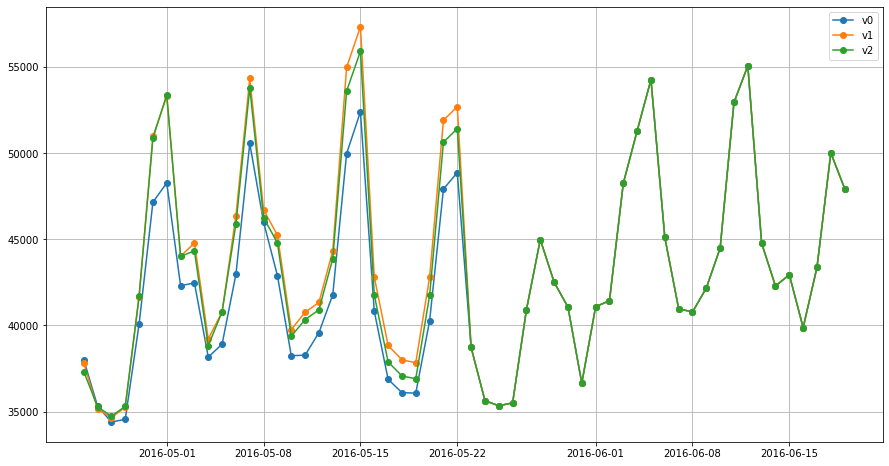

In [12]:
plt.figure(figsize=(15,8))
plt.plot_date(fcst_level01_v0.ds, fcst_level01_v0.y_pred, "o-", label="v0")
plt.plot_date(fcst_level01_v1.ds, fcst_level01_v1.y_pred, "o-", label="v1")
plt.plot_date(fcst_level01_v2.ds, fcst_level01_v2.y_pred, "o-", label="v2")
plt.grid()
plt.legend(loc="best")
plt.show()

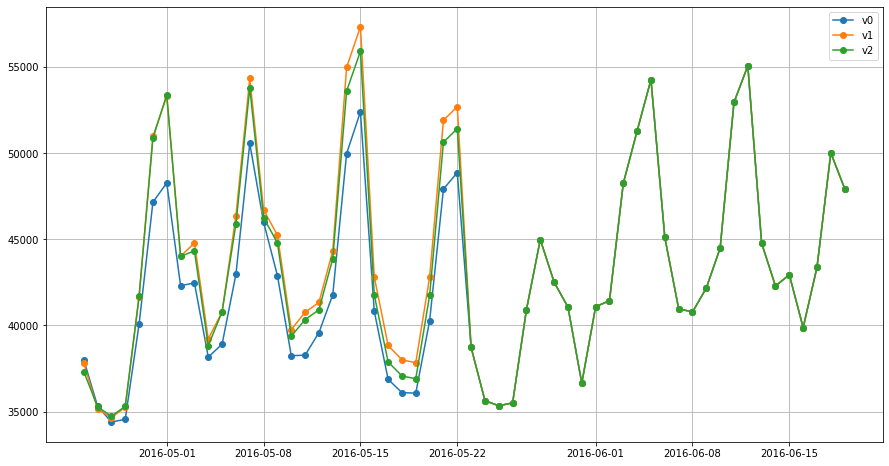

In [34]:
plt.figure(figsize=(15,8))
plt.plot_date(fcst_level01_v0.ds, fcst_level01_v0.y_pred, "o-", label="v0")
plt.plot_date(fcst_level01_v1.ds, fcst_level01_v1.y_pred, "o-", label="v1")
plt.plot_date(fcst_level01_v2.ds, fcst_level01_v2.y_pred, "o-", label="v2")
plt.grid()
plt.legend(loc="best")
plt.show()

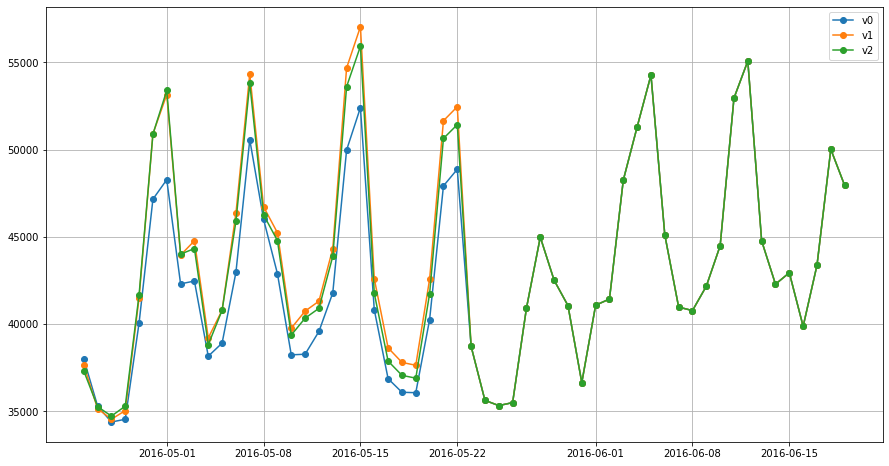

In [11]:
plt.figure(figsize=(15,8))
plt.plot_date(fcst_level01_v0.ds, fcst_level01_v0.y_pred, "o-", label="v0")
plt.plot_date(fcst_level01_v1.ds, fcst_level01_v1.y_pred, "o-", label="v1")
plt.plot_date(fcst_level01_v2.ds, fcst_level01_v2.y_pred, "o-", label="v2")
plt.grid()
plt.legend(loc="best")
plt.show()

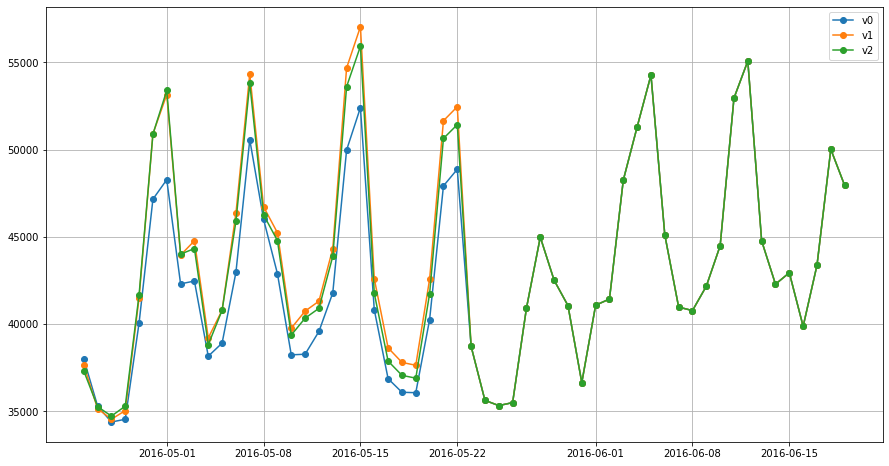

In [12]:
plt.figure(figsize=(15,8))
plt.plot_date(fcst_level01_v0.ds, fcst_level01_v0.y_pred, "o-", label="v0")
plt.plot_date(fcst_level01_v1.ds, fcst_level01_v1.y_pred, "o-", label="v1")
plt.plot_date(fcst_level01_v2.ds, fcst_level01_v2.y_pred, "o-", label="v2")
plt.grid()
plt.legend(loc="best")
plt.show()

***

In [17]:
!ls ../output | grep forecast_level1

forecast_level1-v1.csv
forecast_level1-v2.csv
forecast_level1-v3.csv
forecast_level12_hts.csv
forecast_level1_hts.csv


In [18]:
forecast_level1_valid = (
    pd.read_csv("../output/forecast_level1-v2.csv", parse_dates=["ds"])
    .query("ds <= '2016-05-22'")
    .set_index("ds")
    .rename({"y_pred":"root"}, axis=1)
)

forecast_level1_eval = (
    pd.read_csv("../output/forecast_level1-v2.csv", parse_dates=["ds"])
    .query("ds >= '2016-05-23'")
    .set_index("ds")
    .rename({"y_pred":"root"}, axis=1)
)
    
if "_internal_ts_uid" in forecast_level1_valid.columns:
    forecast_level1_valid.drop("_internal_ts_uid", axis=1, inplace=True)
if "_internal_ts_uid" in forecast_level1_eval.columns:
    forecast_level1_eval.drop("_internal_ts_uid", axis=1, inplace=True)

In [19]:
forecast_level1_valid["root"] = witch_time.loc[0:30489, [f"F{i}" for i in range(1,29)]].values.sum(axis=0)

In [20]:
forecast_level2_valid = (
    pd.read_csv("../output/forecast_level2-v2.csv", parse_dates=["ds"])
    .query("ds <= '2016-05-22'")
    .assign(state_id = lambda x: encoders["state"].inverse_transform(x.state_id))
    .pivot(index="ds", columns="state_id", values="y_pred")
)

forecast_level2_eval = (
    pd.read_csv("../output/forecast_level2-v2.csv", parse_dates=["ds"])
    .query("ds >= '2016-05-23'")
    .assign(state_id = lambda x: encoders["state"].inverse_transform(x.state_id))
    .pivot(index="ds", columns="state_id", values="y_pred")
)

In [21]:
forecast_level2_valid.head()

state_id,CA,TX,WI
ds,,,
2016-04-25,16786.189395,10527.451995,10703.247911
2016-04-26,15536.477508,9571.608107,10331.637208
2016-04-27,15034.834876,9250.658205,10174.905633
2016-04-28,15101.960522,9254.951179,10290.048591
2016-04-29,17131.933899,10351.042404,12699.870593


In [22]:
forecast_level3_valid = (
    pd.read_csv("../output/forecast_level3-v2.csv", parse_dates=["ds"])
    .query("ds <= '2016-05-22'")
    .assign(store_id = lambda x: encoders["store"].inverse_transform(x.store_id))
    .pivot(index="ds", columns="store_id", values="y_pred")
)

forecast_level3_eval = (
    pd.read_csv("../output/forecast_level3-v2.csv", parse_dates=["ds"])
    .query("ds >= '2016-05-23'")
    .assign(store_id = lambda x: encoders["store"].inverse_transform(x.store_id))
    .pivot(index="ds", columns="store_id", values="y_pred")
)

In [23]:
witch_time_ = pd.melt(witch_time.loc[:30489, :], id_vars="id", value_vars=[f"F{i}" for i in range(1, 29)], var_name="d", value_name="q")
witch_time_["id"] = witch_time_.id.apply(lambda x: x.split("_validation")[0])

witch_time_ =  (
    pd.merge(witch_time_, hierarchy.loc[:, ["id","store_id"]], how="left")
    .groupby(["d","store_id"])["q"].sum().reset_index()
)
witch_time_["d"] = witch_time_.d.map(date_mapping1)
witch_time_.rename({"d":"ds"}, axis=1, inplace=True)
witch_time_ = witch_time_.pivot(index="ds", columns="store_id", values="q")
witch_time_

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
ds,,,,,,,,,,
2016-04-25,4187.578546,3888.985485,5969.266195,2698.808985,3035.125218,3734.598041,3643.109081,3152.455798,4250.930017,3249.162236
2016-04-26,3724.124068,3733.425467,5412.365994,2514.465930,2876.641049,3263.599731,3366.434780,3072.700874,4115.704489,3072.494353
2016-04-27,3661.708658,3717.918311,5200.260538,2456.045547,2772.669032,3331.847063,3230.697021,3173.392228,4158.587226,2940.883777
2016-04-28,3719.568092,3840.270826,5107.248987,2509.772165,2756.072493,3421.597544,3274.888539,3270.589933,4340.897794,3016.433327
2016-04-29,4593.087954,4671.476130,5707.447760,2732.095517,3050.053736,3822.967699,3682.281606,4157.150513,5298.802465,3942.458501
2016-04-30,6095.164889,6146.185704,6951.112391,3179.594635,3886.198663,4755.287406,4279.364556,5364.932594,5544.485485,4769.476738
2016-05-01,6837.519124,5827.697455,8069.732907,3314.731928,4515.172594,5219.617833,5061.569206,4374.194062,5677.099879,4409.325657
2016-05-02,4864.359080,4062.324819,6703.912708,2958.834271,3220.509302,3912.284658,4048.750064,3564.197041,6223.594920,4458.273873
2016-05-03,4621.981490,4043.579512,6521.442950,2801.125216,3336.296911,3965.955051,4365.451740,3634.447593,6864.633927,4637.129720


In [24]:
forecast_level3_valid = witch_time_.copy(deep=True)

***

In [26]:
#hierarchy_dict = {"root":hierarchy.id.unique()}

hierarchy_dict = {"root":hierarchy.store_id.unique()}

#hierarchy_dict = {"root":hierarchy.state_id.unique()}

#for state_id in hierarchy.state_id.unique():
#    hierarchy_dict[state_id] = hierarchy.query("state_id == @state_id").id.unique()

#for state_id in hierarchy.state_id.unique():
#    hierarchy_dict[state_id] = hierarchy.query("state_id == @state_id").store_id.unique()
    
for store_id in hierarchy.store_id.unique():
    hierarchy_dict[store_id] = hierarchy.query("store_id == @store_id").id.unique()

In [27]:
%%time
hts = HTSDistributor(hierarchy_dict)

CPU times: user 4min 5s, sys: 13.2 s, total: 4min 18s
Wall time: 4min 18s


In [28]:
forecast_valid = pd.concat([forecast_level1_valid, 
                            #forecast_level2_valid, 
                            forecast_level3_valid, 
                            forecast_level12_valid
                           ],
                           axis=1)

In [29]:
#forecast_eval = pd.concat([forecast_level1_eval, forecast_level2_eval, forecast_level3_eval, forecast_level12_eval],
#                           axis=1)

***
### weights

In [49]:
#residuals_level1 = 612.2047221277929
residuals_level1 = 1

In [50]:
residuals_level2 = pd.read_parquet("../output/residuals_level2-v4.parquet")
residuals_level2["state_id"] = encoders["state"].inverse_transform(residuals_level2.state_id)
residuals_level2

,state_id,residual
0,CA,412.732701
1,TX,362.774696
2,WI,374.457697


In [51]:
residuals_level3 = pd.read_parquet("../output/residuals_level3-v4.parquet")
residuals_level3["store_id"] = encoders["store"].inverse_transform(residuals_level3.store_id)
residuals_level3["residual"] = 1
residuals_level3

,store_id,residual
0,CA_1,1
1,CA_2,1
2,CA_3,1
3,CA_4,1
4,TX_1,1
5,TX_2,1
6,TX_3,1
7,WI_1,1
8,WI_2,1
9,WI_3,1


In [52]:
# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage

In [53]:
scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales_level12 = compute_scaling(scaling_input, agg_columns=["item_id","store_id"]).rename({"q":"s"}, axis=1)

In [54]:
residuals_level12 = scales_level12.rename({"s":"residual"}, axis=1)

In [55]:
residuals_level12.residual.describe()

count    30490.000000
mean         1.848893
std          2.112452
min          0.156826
25%          0.823794
50%          1.289393
75%          2.058024
max         70.212305
Name: residual, dtype: float64

In [56]:
residuals_level12["item_id"] = encoders["item"].inverse_transform(residuals_level12.item_id)
residuals_level12["store_id"] = encoders["store"].inverse_transform(residuals_level12.store_id)
residuals_level12 = pd.merge(hierarchy.loc[:, ["store_id","item_id","id"]],
                             residuals_level12,
                             how="left", 
                             on=["item_id","store_id"])

# in case of missing item_id,store_id in residuals dataframe
#residuals_level12["residual"] = residuals_level12.residual.fillna(residuals_level12.residual.median())

# cuts-off the minimal residual to keep bounded the condition number of the X matrix.
#residual_limit = residuals_level12.residual.quantile(0.01)
#print(f"residual_limit: {residual_limit}")  
#idx = residuals_level12.query("residual <= @residual_limit").index
#residuals_level12.loc[idx, "residual"] = residual_limit

# hard truncation
#residuals_level12.loc[residuals_level12.query("residual < 1").index, "residual"] = 1

# shifting
#residuals_level12.loc[:, "residual"] += (1-residuals_level12.residual.min())

# set to 1 all level 12
#residuals_level12.loc[:, "residual"] = 1

residuals_level12

,store_id,item_id,id,residual
0,CA_1,HOBBIES_1_001,HOBBIES_1_001_CA_1,1.168326
1,CA_1,HOBBIES_1_002,HOBBIES_1_002_CA_1,0.782439
2,CA_1,HOBBIES_1_003,HOBBIES_1_003_CA_1,0.886355
3,CA_1,HOBBIES_1_004,HOBBIES_1_004_CA_1,2.681374
4,CA_1,HOBBIES_1_005,HOBBIES_1_005_CA_1,1.634013
...,...,...,...,...
30485,WI_3,FOODS_3_823,FOODS_3_823_WI_3,1.158398
30486,WI_3,FOODS_3_824,FOODS_3_824_WI_3,1.019218
30487,WI_3,FOODS_3_825,FOODS_3_825_WI_3,1.516351
30488,WI_3,FOODS_3_826,FOODS_3_826_WI_3,1.475389


***

In [57]:
#func = lambda x: np.log1p(x)
#func = lambda x: x**1
#func = lambda x: x*np.log1p(x)
func = lambda x: x**1

weights_level12 = {row["id"] : 1./func(row["residual"]) for _,row in residuals_level12.iterrows()}
weights_level3 = {row["store_id"] : 1./func(row["residual"]) for _,row in residuals_level3.iterrows()}
weights_level2 = {row["state_id"] : 1./func(row["residual"]) for _,row in residuals_level2.iterrows()}
weights_level1 = {"root" : 1./func(residuals_level1)}

In [58]:
#weights = {**weights_level1, **weights_level2, **weights_level3, **weights_level12}
weights = {**weights_level1, **weights_level3, **weights_level12}

***
### estimation of bounds

In [59]:
#residuals_raw = pd.read_parquet("../output/residuals_raw_lgbm_bottom_v95.parquet")
#df = residuals_raw.groupby(["item_id","store_id"])["residual"].mean().reset_index()

***

In [60]:
#%%time
#fcst_valid = hts.compute_forecast_proportions(forecast_valid)

In [61]:
%%time
fcst_valid = hts.compute_optimal_combination(forecast_valid,
                                             weights=weights,
                                             backend="lsmr",
                                             solver_kwargs={"atol":1e-8,
                                                            "btol":1e-8,
                                                            "maxiter":1e6})
 

fcst_valid.head(10)

----------------------------------------------------------------------------------------------------
---------------------------- Reconciling time step: 2016-04-25 00:00:00 ----------------------------
----------------------------------------------------------------------------------------------------
stop: 2. x approximately solves the least-squares problem according to atol.
n-iterations: 2307
r1norm norm(r): 1.075275937710086
Ar-norm: 4.199581824586929e-05
A-norm: 3925.5394991774383
A-cond: 603.7164515902263
x-norm: 498.48052394005185
----------------------------------------------------------------------------------------------------
---------------------------- Reconciling time step: 2016-04-26 00:00:00 ----------------------------
----------------------------------------------------------------------------------------------------
stop: 2. x approximately solves the least-squares problem according to atol.
n-iterations: 2627
r1norm norm(r): 0.28707473289836893
Ar-norm: 1.1867226782

,root,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,...,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
0,37810.017590,4187.579253,3888.983625,5969.267098,2698.808363,3035.125692,3734.598542,3643.109111,3152.454594,4250.929165,...,1.699468,1.628351,1.459842,0.797340,1.883980,0.343854,0.267760,0.627510,1.003146,0.209843
1,35151.957219,3724.124368,3733.425360,5412.366188,2514.466350,2876.641303,3263.599730,3366.434970,3072.700813,4115.704002,...,1.575423,1.549695,1.300956,0.739998,1.684462,0.305662,0.219989,0.521343,0.907928,1.127107
2,34644.009750,3661.709082,3717.918340,5200.260843,2456.046084,2772.669396,3331.847211,3230.697321,3173.391879,4158.586166,...,1.502903,1.516518,1.251907,0.733293,1.674672,0.305877,0.183326,0.471177,0.758296,1.155793
3,35257.339655,3719.570792,3840.267048,5107.251204,2509.772211,2756.073965,3421.597587,3274.888584,3270.589978,4340.894915,...,1.436014,1.555577,1.271788,0.783212,1.724988,0.291247,0.205312,0.488638,0.803344,1.653971
4,41657.822007,4593.088636,4671.476006,5707.448233,2732.095883,3050.054239,3822.967858,3682.281850,4157.150388,5298.800538,...,1.781492,2.003033,1.473252,1.001677,1.994212,0.352295,0.247020,0.628324,0.883420,2.071246
5,50971.802741,6095.165166,6146.185713,6951.112682,3179.594671,3886.198983,4755.287549,4279.364663,5364.932544,5544.483919,...,1.820093,2.280332,1.736363,1.357132,2.670754,0.439340,0.321037,0.776057,1.220031,2.576373
6,53306.660920,6837.520291,5827.697179,8069.733646,3314.732249,4515.173333,5219.617945,5061.569437,4374.193786,5677.097672,...,1.707772,2.020761,1.620185,1.163227,2.762066,0.446427,0.316065,0.947372,1.148522,2.484252
7,44017.040722,4864.359776,4062.324832,6703.913282,2958.834816,3220.509513,3912.284670,4048.750077,3564.197054,6223.592816,...,2.055572,2.742502,1.937691,1.181527,3.000340,0.415796,0.354473,1.078247,1.193199,2.008059
8,44792.042084,4621.983518,4043.578504,6521.444976,2801.124016,3336.298937,3965.955185,4365.450965,3634.445910,6864.631327,...,2.145020,3.038984,1.873688,1.114623,2.885761,0.499556,0.368046,1.180000,1.256914,2.137283
9,39213.194805,4316.259009,3892.092950,6010.469769,2685.980852,2971.445398,3503.973184,3638.246115,3401.358054,5227.162776,...,1.685307,2.022105,1.430620,0.863076,2.230001,0.375345,0.288592,0.814387,0.928255,1.782724


In [63]:
forecast_valid.head()

,root,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,...,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
2016-04-25,37810.019602,4187.578546,3888.985485,5969.266195,2698.808985,3035.125218,3734.598041,3643.109081,3152.455798,4250.930017,...,1.691279,1.605128,1.451438,0.790715,1.862003,0.341034,0.265576,0.622677,0.998571,0.195621
2016-04-26,35151.956733,3724.124068,3733.425467,5412.365994,2514.465930,2876.641049,3263.599731,3366.434780,3072.700874,4115.704489,...,1.576473,1.552673,1.302033,0.740847,1.687279,0.306024,0.220269,0.521962,0.908515,1.128930
2016-04-27,34644.009401,3661.708658,3717.918311,5200.260538,2456.045547,2772.669032,3331.847063,3230.697021,3173.392228,4158.587226,...,1.502902,1.516518,1.251907,0.733293,1.674671,0.305877,0.183326,0.471177,0.758296,1.155793
2016-04-28,35257.339700,3719.568092,3840.270826,5107.248987,2509.772165,2756.072493,3421.597544,3274.888539,3270.589933,4340.897794,...,1.436012,1.555572,1.271787,0.783211,1.724985,0.291247,0.205311,0.488638,0.803343,1.653968
2016-04-29,41657.821882,4593.087954,4671.476130,5707.447760,2732.095517,3050.053736,3822.967699,3682.281606,4157.150513,5298.802465,...,1.781492,2.003033,1.473251,1.001677,1.994211,0.352295,0.247020,0.628324,0.883420,2.071246


***

In [63]:
forecast = forecast_valid.head(7).tail(1)

In [66]:
X = hts.sparse_summing_matrix

In [67]:
y = forecast.loc[:, hts.tree_nodes].values

In [70]:
beta = forecast.loc[:, hts.bottom_nodes].values.ravel()
beta = fcst_valid.head(7).tail(1).loc[:, hts.bottom_nodes].values.ravel()

In [71]:
np.linalg.norm(X.dot(beta) - y)

1049.5837492459596

***

In [64]:
fcst_valid.set_index(forecast_valid.index, inplace=True)
fcst_valid = fcst_valid.loc[:, hts.bottom_nodes].transpose()
fcst_valid.columns = [f"F{i}" for i in range(1,29)]
fcst_valid = (fcst_valid
              .reset_index()
              .rename({"index":"id"}, axis=1))
fcst_valid["id"] = fcst_valid.id.apply(lambda x: x+"_validation")

#fcst_eval.set_index(forecast_eval.index, inplace=True)
#fcst_eval = fcst_eval.loc[:, hts.bottom_nodes].transpose()
#fcst_eval.columns = [f"F{i}" for i in range(1,29)]
#fcst_eval= (fcst_eval
#              .reset_index()
#              .rename({"index":"id"}, axis=1))
#fcst_eval["id"] = fcst_eval.id.apply(lambda x: x+"_evaluation")

***
### submission

In [65]:
submission = pd.read_csv("../input/sample_submission.csv")
submission = pd.merge(submission.loc[:, ["id"]], fcst_valid, how="left")
submission.fillna(0, inplace=True)

In [66]:
!ls -halt ../output | grep .csv.gz | head -10

-rw-r--r--.  1 turing turing 7.0M May 31 22:12 lgbm_bottom_v140.csv.gz
-rw-r--r--.  1 turing turing 7.5M May 31 06:11 lgbm_bottom_v139.csv.gz
-rw-r--r--.  1 turing turing 7.0M May 31 04:17 lgbm_bottom_v138.csv.gz
-rw-r--r--.  1 turing turing 7.5M May 31 02:16 lgbm_bottom_v137.csv.gz
-rw-r--r--.  1 turing turing 7.0M May 30 23:30 lgbm_bottom_v136.csv.gz
-rw-r--r--.  1 turing turing 7.5M May 30 22:53 lgbm_bottom_v135.csv.gz
-rw-r--r--.  1 turing turing 6.9M May 30 21:25 lgbm_bottom_v134.csv.gz
-rw-r--r--.  1 turing turing 6.3M May 30 07:26 lgbm_bottom_v133.csv.gz
-rw-r--r--.  1 turing turing 7.1M May 29 22:40 lgbm_bottom_v132.csv.gz
-rw-r--r--.  1 turing turing 7.0M May 29 20:52 lgbm_bottom_v131.csv.gz


In [67]:
file_path = "../output/lgbm_bottom_v141.csv.gz"

if os.path.isfile(file_path):
    print("File already exists.")
else:
    submission.to_csv(file_path, index=False, compression="gzip")

In [68]:
!kaggle competitions submit -c m5-forecasting-accuracy -f ../output/lgbm_bottom_v141.csv.gz -m ""

100%|██████████████████████████████████████| 7.46M/7.46M [00:02<00:00, 3.25MB/s]
Successfully submitted to M5 Forecasting - Accuracy

***